# Hito 2 - Grupo 8
## Intregrantes
- Vicente González
- Rodrigo Iturrieta
- Pablo Jaramillo
- Cristian Lillo
- Benjamín Valenzuela

## Material

- [Repositorio](https://github.com/propublica/compas-analysis)
- [Video (hito 1)](https://drive.google.com/file/d/1TNpHXC2bTTwXfvSc1zU21SxwGIv-3yGU/view?usp=sharing)


## Introducción

Durante la última década, la sociedad moderna ha estado expuesta a un periodo de disconformidad y crisis. Múltiples protestas han ocurrido a lo largo del mundo, donde se evidencian malestares en temas de discriminación, igualdad y justicia.

Uno de estos movimientos es el de Black Lives Matter, donde la población afroamericana de Estados Unidos ha dejado claro que existe, a dia de hoy, un trato desigual debido a la etnia de la persona, donde se mostró al mundo entero un sistema que los desfavorecía enormemente o directamente no esperaban nada de ellos.

La motivación del equipo nace a raíz de estas problemáticas, donde, además, desde un punto de vista de *data mining*, salta a la vista la pregunta: ¿Se puede hacer un modelo que consiga evidenciar la discriminación en una base de datos?

Particularmente, para abarcar esta problemática, se decidió dar enfoque al caso de estudio de COMPAS. En este, se encontró que el modelo predictivo **COMPAS** (Correctional Offender Management Profiling for Alternative Sanctions) otorgaba una evaluación de riesgo mayor a personas afroamericanas que al resto. Es decir, que el modelo "discriminaba" a ciertos grupos de personas basadas en su etnia, marcándolas como potencialmente más propensos a cometer un crimen.

La idea central del proyecto es poder construir un modelo a partir de los datos de COMPAS, para poder evaluar la discriminación en la base de datos. Identificando, además los parámetros bajo los cuales COMPAS hace la discriminación.

## Exploración de datos

- [Ver hito 1](hito-1.html)

## Preguntas y Problemas

Dado el análisis realizado, se formularon las siguientes preguntas:

1. ¿Qué características describen mejor un factor de reincidencia?

    El factor 

2. ¿Existirán grupos de personas que compartan la misma tasa de reincidencia? Si existen, ¿Qué atributos componen a dichos grupos?

    Identificar grupos naturales dentro de los datos mostrará de manera más clara si existe algun tipo de sesgo con respecto a la etnia de una persona.

3. ¿Es posible predecir la etnia de una persona en base a atributos del análisis de COMPAS?

    Dependiendo de la eficaz que sea un modelo entrenado con los datos entregados por COMPAS a la hora de predecir la etnia, podemos concluir si existe realmente racismo por parte del modelo.
    
4. Con los datos que se tienen ¿Qué tan bien se puede (predecir/agrupar/clasificar) el decile_score?

    Es importante poder identficar correctamente los aspectos que influyen en el decile score, para así poder ver si en realidad los resultados se ven afectados por la etnia, o es algún otro parámetro que a su vez este estrechamente relacionado con la etnia, ya sea por temas culturales o sociales.

## Propuesta experimental
Para llevar a cabo la investigación se utilizará la siguiente metodología:
P1
- Identificamos los atributos importantes usando matriz de correlación y p-values
- Entrenar modelos clasificadores usando gridsearch
- Seleccionar los mejores atributos de cada modelo
- Evaluar los mejores modelos usando F1
- Repetir hasta encontrar un modelo satisfactorio, en caso contrario, igualmente se puede concluir

P2
- Aplicamos modelos de clustering sobre los datos.
- Buscamos encontrar clusters que posean homogeneidad con respecto al factor de reincidencia.
- Una vez identificado grupos, usar matrices de correlación para encontrar elementos relacionados dentro de un mismo grupo



## Resultado reliminar

In [10]:
# Imports iniciales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB  # naive bayes
from sklearn.neighbors import KNeighborsClassifier #kNN
from sklearn.svm import SVC  # support vector machine

In [11]:
# Los datos cargados con R, los pasamos a csv, para luego leerlos con pandas
casearrest = pd.read_csv('../data/cleaned/casearrest_cl.csv')
compas_failure=pd.read_csv('../data/cleaned/compas_failure_cl.csv')
jailhistory=pd.read_csv('../data/cleaned/jailhistory_cl.csv')
people_charge=pd.read_csv('../data/original/people_charge.csv')
people=pd.read_csv('../data/cleaned/people_cl.csv')
prisonhistory=pd.read_csv('../data/cleaned/prisonhistory_cl.csv')
compas_recid=pd.read_csv('../data/cleaned/compas_recid_cl.csv')
compas_violence=pd.read_csv('../data/cleaned/compas_violence_cl.csv')


Queremos ver como si se puede predecir la recidividad, para eso necesitaremos la tabla "people" hasta la columna "is_recid".

In [12]:
# !!!
dataset = people[people.columns[1:-9]].drop(columns=["age", "race", "c_charge_degree","c_offense_date"])
dataset['sex'] = np.where(dataset['sex']=='Male',1,0)

Contexto heatmap/correlacion 1

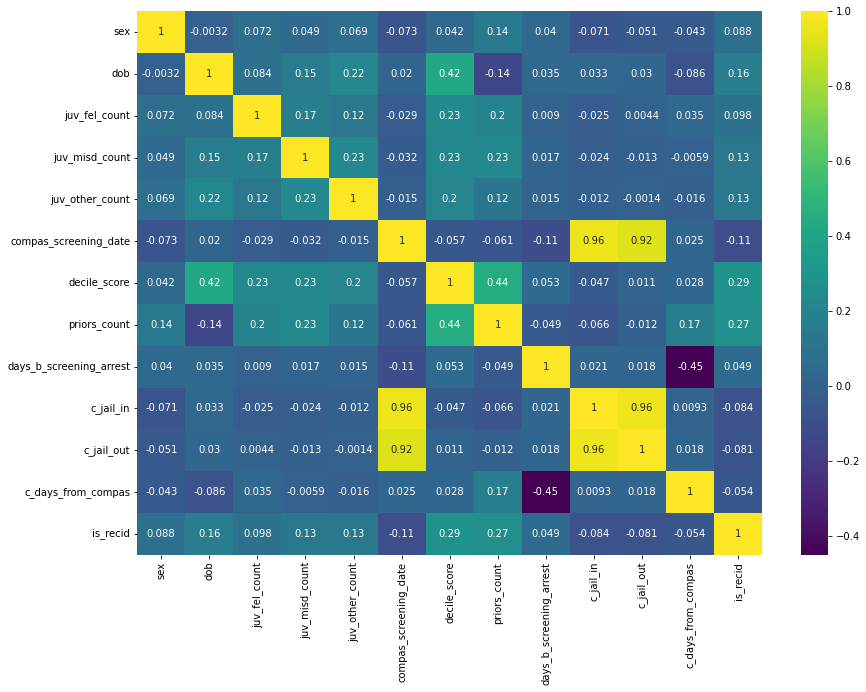

In [13]:
norm_dataset = (dataset -dataset.min())/(dataset.max() -dataset.min())
plt.figure(figsize=(14, 10))
sns.heatmap(norm_dataset.corr(method='spearman'), cmap='viridis', annot=True);

Contexto heatmap/correlacion 2

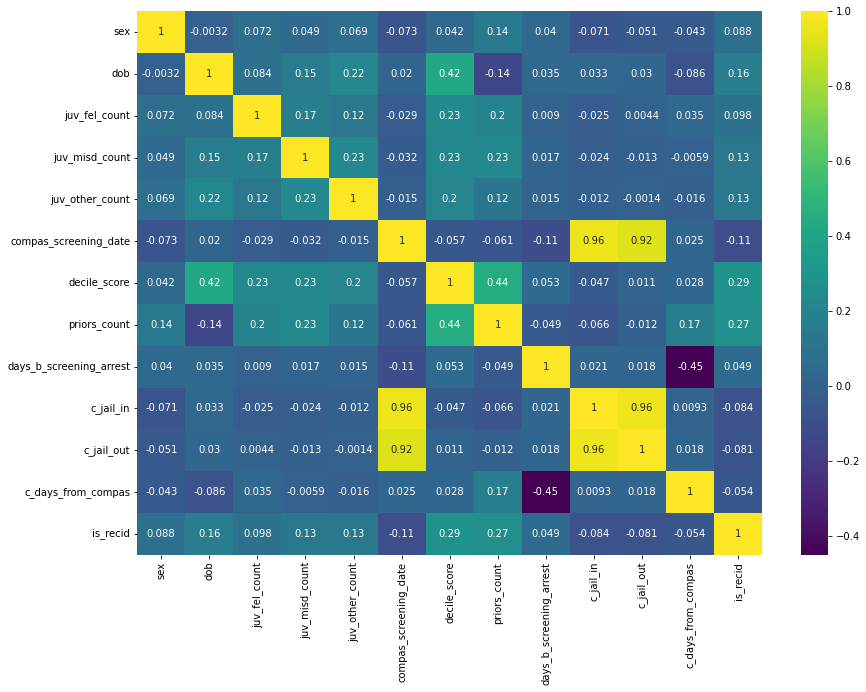

In [14]:
plt.figure(figsize=(14, 10))
sns.heatmap(dataset.corr(method='spearman'), cmap='viridis', annot=True);

Resultados heatmaps/correlacion

Entrenar modelos usando GridSearch norm_dataset (datos normalizados (?))

In [15]:
###separamos valores
data_train, data_test, y_train, y_test = train_test_split(norm_dataset, norm_dataset['is_recid'], test_size=.30,
                                                    random_state=15, stratify=norm_dataset['is_recid'])
##subsampleamos
data_train = data_train.reset_index(drop=True)
idx = np.random.choice(data_train.loc[data_train.is_recid == 0].index, size=2545, replace=False)
data_subsampled = data_train.drop(data_train.iloc[idx].index)
##Oversamplemaos
idx = np.random.choice(data_train[data_train['is_recid'] == 1].index, size=2545)
data_oversampled = data_train.drop(data_train.iloc[idx].index)

### dejamos los datos para trabajar
y_test = data_test.is_recid
X_test = data_test.drop(columns=['is_recid'])
y_orig =data_train.is_recid
X_orig = data_train.drop(columns=['is_recid'])
y_subs=data_subsampled.is_recid
X_subs=data_subsampled.drop(columns=['is_recid'])
y_over=data_oversampled.is_recid
X_over=data_oversampled.drop(columns=['is_recid'])

#Configure tuned_parameters
tuned_parameters = {'n_neighbors': [1, 3, 5, 10],
                    'weights': ['uniform','distance']}
score = 'f1'

### modelo del original
clf_org = GridSearchCV(KNeighborsClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" ORIG Mejor combinación de parámetros:")
clf_org.fit(X_orig,y_orig)
print(clf_org.best_params_)

y_pred = clf_org.predict(X_test)

print(classification_report(y_test, y_pred))
### modelo subsampling
clf_sub = GridSearchCV(KNeighborsClassifier(),
                   param_grid=tuned_parameters,
                   cv=5,
                   scoring=score)
print(" SUB Mejor combinación de parámetros:")
clf_sub.fit(X_subs,y_subs)
print(clf_sub.best_params_)

y_pred = clf_sub.predict(X_test)

print(classification_report(y_test, y_pred))
### modelo oversampling
clf_over = GridSearchCV(KNeighborsClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" OVER Mejor combinación de parámetros:")
clf_over.fit(X_over,y_over)
print(clf_over.best_params_)

y_pred = clf_over.predict(X_test)

print(classification_report(y_test, y_pred))

 ORIG Mejor combinación de parámetros:
{'n_neighbors': 10, 'weights': 'distance'}
              precision    recall  f1-score   support

         0.0       0.73      0.83      0.78      2195
         1.0       0.54      0.39      0.45      1104

    accuracy                           0.69      3299
   macro avg       0.64      0.61      0.62      3299
weighted avg       0.67      0.69      0.67      3299

 SUB Mejor combinación de parámetros:
{'n_neighbors': 10, 'weights': 'distance'}
              precision    recall  f1-score   support

         0.0       0.77      0.63      0.69      2195
         1.0       0.46      0.62      0.53      1104

    accuracy                           0.63      3299
   macro avg       0.61      0.63      0.61      3299
weighted avg       0.66      0.63      0.64      3299

 OVER Mejor combinación de parámetros:
{'n_neighbors': 1, 'weights': 'uniform'}
              precision    recall  f1-score   support

         0.0       0.70      0.88      0.78     

Heatmap/correlacion con etnia y sexo binarios

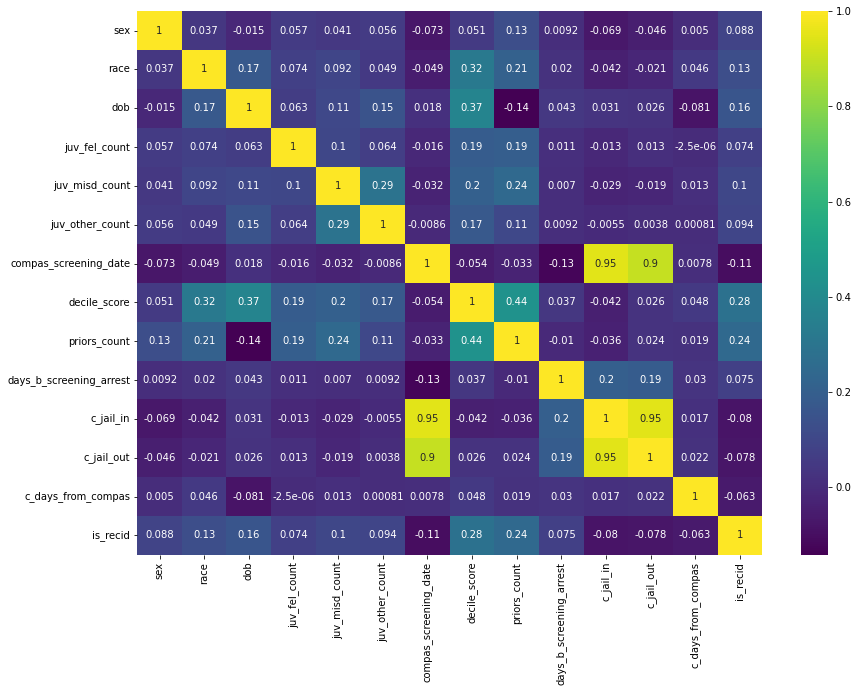

In [16]:
peoplemejor=people.copy()
peoplemejor['race'] = np.where(peoplemejor['race']=='African-American',1,0)
peoplemejor['sex'] = np.where(peoplemejor['sex']=='Male',1,0)
peoplemejor = peoplemejor[peoplemejor.columns[1:-9]].drop(columns=["age", "c_charge_degree","c_offense_date"])
plt.figure(figsize=(14, 10))
sns.heatmap(peoplemejor.corr(), cmap='viridis', annot=True);

Entrenar modelos usando GridSearch peoplemejor (etnia y sexo binarios)

In [17]:
##########################  KNeighbors con raza
###separamos valores
X_train, X_test, y_train, y_test = train_test_split(peoplemejor, peoplemejor['is_recid'], test_size=.30,
                                                          random_state=15, stratify=peoplemejor['is_recid'])
##subsampleamos
X_train = X_train.reset_index(drop=True)
idx = np.random.choice(X_train.loc[X_train.is_recid == 0].index, size=2545, replace=False)
data_subsampled = X_train.drop(X_train.iloc[idx].index)
##Oversamplemaos
idx = np.random.choice(X_train[X_train['is_recid'] == 1].index, size=2545)
data_oversampled = X_train.drop(X_train.iloc[idx].index)
### dejamos los datos para trabajar
y_test = X_test.is_recid
X_test = X_test.drop(columns=['is_recid'])
y_orig =X_train.is_recid
X_orig = X_train.drop(columns=['is_recid'])
y_subs=data_subsampled.is_recid
X_subs=data_subsampled.drop(columns=['is_recid'])
y_over=data_oversampled.is_recid
X_over=data_oversampled.drop(columns=['is_recid'])

#Configure tuned_parameters
tuned_parameters = {'n_neighbors': [1, 3, 5, 10],
                    'weights': ['uniform','distance']}
score = 'f1'

### modelo del original
clf_org = GridSearchCV(KNeighborsClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" ORG Mejor combinación de parámetros:")
clf_org.fit(X_orig,y_orig)
print(clf_org.best_params_)

y_pred = clf_org.predict(X_test)

print(classification_report(y_test, y_pred))
### modelo subsampling
clf_sub = GridSearchCV(KNeighborsClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" SUB Mejor combinación de parámetros:")
clf_sub.fit(X_subs,y_subs)
print(clf_sub.best_params_)

y_pred = clf_sub.predict(X_test)

print(classification_report(y_test, y_pred))
### modelo oversampling
clf_over = GridSearchCV(KNeighborsClassifier(),
                        param_grid=tuned_parameters,
                        cv=5,
                        scoring=score)
print(" OVER Mejor combinación de parámetros:")
clf_over.fit(X_over,y_over)
print(clf_over.best_params_)

y_pred = clf_over.predict(X_test)

print(classification_report(y_test, y_pred))

 ORG Mejor combinación de parámetros:
{'n_neighbors': 10, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.72      0.81      0.77      2195
           1       0.51      0.38      0.44      1104

    accuracy                           0.67      3299
   macro avg       0.62      0.60      0.60      3299
weighted avg       0.65      0.67      0.66      3299

 SUB Mejor combinación de parámetros:
{'n_neighbors': 5, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.77      0.65      0.71      2195
           1       0.47      0.62      0.54      1104

    accuracy                           0.64      3299
   macro avg       0.62      0.64      0.62      3299
weighted avg       0.67      0.64      0.65      3299

 OVER Mejor combinación de parámetros:
{'n_neighbors': 1, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.69      0.87      0.77      21

GridSearch, ahora con Decision Tree (usando tabla people)

In [18]:
dataset = people[people.columns[1:-9]].drop(columns=["age", "race", "c_charge_degree","c_offense_date"])
dataset["sex"] = np.where(dataset["sex"]=='Male',1,0)

# Get training and testing data for dataset, subsampled dataset and oversampled dataset
X_train, X_test, y_train, y_test = train_test_split(dataset, dataset['is_recid'], test_size=.30,
                                                            random_state=15, stratify=dataset['is_recid'])

# Subsample the data
X_train = X_train.reset_index(drop=True)
idx = np.random.choice(X_train.loc[X_train.is_recid == 0].index, size=2545, replace=False)
data_subsampled = X_train.drop(X_train.iloc[idx].index)
# Oversample the data
idx = np.random.choice(X_train[X_train['is_recid'] == 1].index, size=2545)
data_oversampled = X_train.drop(X_train.iloc[idx].index)

# Get the test data
y_test = X_test.is_recid
X_test = X_test.drop(columns=['is_recid'])
# Get the training data
y_orig =X_train.is_recid
X_orig = X_train.drop(columns=['is_recid'])
# Get the subsampled data
y_subs=data_subsampled.is_recid
X_subs=data_subsampled.drop(columns=['is_recid'])
# Get the oversampled data
y_over=data_oversampled.is_recid
X_over=data_oversampled.drop(columns=['is_recid'])

# Find best decision tree classifier using GridSearchCV
tuned_parameters = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                    'criterion': ['gini','entropy']}
score = 'f1'

# Gridsearch with original data
clf_org = GridSearchCV(DecisionTreeClassifier(),
                          param_grid=tuned_parameters,
                            cv=5,
                            scoring=score)

print(" ORG Mejor combinación de parámetros:")
clf_org.fit(X_orig,y_orig)
print(clf_org.best_params_)
y_pred = clf_org.predict(X_test)
print(classification_report(y_test, y_pred))

 ORG Mejor combinación de parámetros:
{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      2195
           1       0.55      0.52      0.53      1104

    accuracy                           0.70      3299
   macro avg       0.66      0.65      0.65      3299
weighted avg       0.69      0.70      0.69      3299



In [19]:
# Gridsearch with SubSampled data
clf_sub = GridSearchCV(DecisionTreeClassifier(),
                          param_grid=tuned_parameters,
                            cv=5,
                            scoring=score)

print(" SUB Mejor combinación de parámetros:")
clf_sub.fit(X_subs,y_subs)
print(clf_sub.best_params_)
y_pred = clf_sub.predict(X_test)
print(classification_report(y_test, y_pred))

 SUB Mejor combinación de parámetros:
{'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.80      0.54      0.65      2195
           1       0.44      0.73      0.55      1104

    accuracy                           0.60      3299
   macro avg       0.62      0.63      0.60      3299
weighted avg       0.68      0.60      0.61      3299



In [20]:
# Gridsearch with OverSampled data
clf_over = GridSearchCV(DecisionTreeClassifier(),
                          param_grid=tuned_parameters,
                            cv=5,
                            scoring=score)

print(" OVER Mejor combinación de parámetros:")
clf_over.fit(X_over,y_over)
print(clf_over.best_params_)
y_pred = clf_over.predict(X_test)
print(classification_report(y_test, y_pred))

 OVER Mejor combinación de parámetros:
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 15}
              precision    recall  f1-score   support

           0       0.68      0.97      0.80      2195
           1       0.58      0.09      0.15      1104

    accuracy                           0.67      3299
   macro avg       0.63      0.53      0.47      3299
weighted avg       0.64      0.67      0.58      3299



## Contribuciones
-   Vicente González: Ayudo a redactar el informe y escribió el guión de la presentación.
-   Rodrigo Iturrieta: Realizo el material de apoyo para la presentación, así como la edición de la misma.
-   Pablo Jaramillo: Encargado de hacer la exploración de datos.
-   Cristián Lillo: Redacto el presente informe.
-   Benjamin Valenzuela: Ayudo a la exploración de datos, asi como en la redacción de la parte final del informe.